## **Deep Learning Made Easy**

----

**Important:** This notebook was developed by Meta (Facebook) AIR and it is an official <a href="https://pytorch.org/hub/facebookresearch_pytorch-gan-zoo_pgan/">PyTorch Tutorial</a>. Some modifications have been done by <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>. It is a notebook about the Progressive Growing of GANs (PROGAN).


<br>

**Licence**: GNU GENERAL PUBLIC LICENSE, Version 3 (GPLv3)

<br>

<img src="https://drive.google.com/uc?id=1GTWiFbgjo8ndlCU76__1wQu8jkDOKBfz" alt="Drawing" width="400"/>



##PROGAN
----

The main idea of PROGAN is to grow both the generator (G) and discriminator (D) progressively. Starting from a low "resolution" (dimension; 4 x 4), layers are incrementally added to G and D, which
increases the resolution for the generated images.

<br>


<img src="https://drive.google.com/uc?id=1F4_0fvyGBtmwas5Cy3eqf12SCW77Mt7G" alt="Drawing" width="400"/>

Source: <a href="https://arxiv.org/abs/1710.10196">PROGAN article</a>.

<br>

Because the resolution is increased little by little, the networks are continuously asked a much simpler question compared
to the end goal of discovering a mapping from latent vectors.

##Generator and Discriminator
----

Generator and discriminator models are basically mirrors of each other and always grow
in synchrony. All existing layers in both networks remain trainable throughout the training process.

<br>


<img src="https://drive.google.com/uc?id=1BhZWazVlldSNgZyiVpKSCILwof1wbrZk" alt="Drawing" width="400"/>

Source: <a href="https://arxiv.org/abs/1710.10196">PROGAN article</a>.

<br>

There are basically four steps accomplished by PROGAN:

1. Progressive growing of generator and discriminator. We have already mentioned it;

2. Increasing variation using mini-batch standard deviation;

3. Normalisation: equalised learning rate;

4. Normalisation: pixelwise feature vector normalisation in generator.


##Increasing variation using mini-batch standard deviation
----

GANs tends to capture only a subset of the variation found in training (target) data. One solution is called mini-batch discrimination where feature statistics are computed not
only from individual images but also across the mini-batch, thus encouraging the mini-batches of
generated and training images to show similar statistics.

<br>

In PROGAN, they adopted a simplified solution where authors first compute
the standard deviation for each feature in each spatial location over the mini-batch. After that, they average
these estimates over all features and spatial locations to arrive at a single value. Hence, they replicate the
value and concatenate it to all spatial locations and over the minibatch, **yielding one additional (constant)
feature map**. This layer could be inserted anywhere in the **discriminator**, but they have done it towards the end.



In [ ]:
import torch
import numpy as np
import math

def minibatch_std(x):
  batch_statistics = (
  torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3]))
  return torch.cat([x, batch_statistics], dim=1)

input_layer = torch.rand((16,3,4,4))
img = 12  
print('Input of layer: ', input_layer[img])
print('Input shape: ', input_layer.shape)
print('#'*20)
output_layer = minibatch_std(input_layer)
print('Output layer:', output_layer[img])
print('Output shape: ', output_layer.shape)

Input of layer:  tensor([[[0.0696, 0.8118, 0.5292, 0.6162],
         [0.4706, 0.2335, 0.8005, 0.7321],
         [0.5893, 0.2028, 0.6891, 0.3911],
         [0.2232, 0.9352, 0.1002, 0.9226]],

        [[0.6811, 0.2329, 0.4421, 0.8742],
         [0.2803, 0.6493, 0.0369, 0.9287],
         [0.1369, 0.5945, 0.1161, 0.2035],
         [0.3840, 0.6594, 0.8060, 0.0669]],

        [[0.7753, 0.1746, 0.7837, 0.8732],
         [0.8273, 0.9377, 0.2071, 0.2318],
         [0.5676, 0.8157, 0.1797, 0.0061],
         [0.5964, 0.5996, 0.0112, 0.0564]]])
Input shape:  torch.Size([16, 3, 4, 4])
####################
Output layer: tensor([[[0.0696, 0.8118, 0.5292, 0.6162],
         [0.4706, 0.2335, 0.8005, 0.7321],
         [0.5893, 0.2028, 0.6891, 0.3911],
         [0.2232, 0.9352, 0.1002, 0.9226]],

        [[0.6811, 0.2329, 0.4421, 0.8742],
         [0.2803, 0.6493, 0.0369, 0.9287],
         [0.1369, 0.5945, 0.1161, 0.2035],
         [0.3840, 0.6594, 0.8060, 0.0669]],

        [[0.7753, 0.1746, 0.7837, 0.87

##Normalisation: Equalised Learning Rate
----

In PROGAN, authors did not adopt a careful weight initialisation (e.g. DCGAN) and instead they relied on a initialisation via a simple standard normal distribution ($\mathcal{N}(0,1)$, and then explicitly scale the weights at runtime. Hence, they used

$$
\hat{\omega_i} = \frac{\omega_i}{c}
$$

where $c$ is the per-layer normalisation constant from <a href="https://arxiv.org/abs/1502.01852">He’s initialiser</a>.

<br>

Why doing this dynamically and not during initialisation? Scale-invariance in commonly used adaptive stochastic gradient descent
methods such as RMSProp and Adam.

<br>

Scale-invariance? See this post by <a href="https://www.inference.vc/exponentially-growing-learning-rate-implications-of-scale-invariance-induced-by-batchnorm/">Ferenc Huszár</a>. 

Quote: "... batch-normalisation renders the loss function of neural networks scale invariant - scaling the weights by a constant does not change the output, or the loss, of the batch normalised network. It turns out that this property alone might result in somewhat unexpected and potentially helpful properties for optimisation."


##Normalisation: Pixelwise Feature Vector (Generation)
----

In order to avoid the magnitudes in the generator and discriminator to be out of control
as a result of competition, in PROGAN authors normalised the feature vector in each pixel to unit length in the
generator after each convolutional layer. Hence:

<img src="https://drive.google.com/uc?id=1R-lZM_kkz2UVKuXxzYwUMDZ8UQR6jCpv" alt="Drawing" width="300"/>



where $\epsilon = 10^{-8}$, $N$ is the number of feature maps, $a_{x,y}$ and $b_{x,y}$ are the original and normalised feature vector in pixel $(x,y)$, respectively. 

<br>

They realised that this does not seem to
damage the performance of the generator, in addition to prevent the escalation of signal magnitudes very effectively when needed.



In [ ]:
# Normalisation: pixelwise. Below, we assume that each pixel can assume values 
# from 0 to 255.
axy = np.random.randint(0,256,32)
#axy = np.random.uniform(-1,1.001,32)
epsilon = 10**(-8)
print('Orig. feat. vector: ', axy)
sum_square = 0
for f in axy:
  sum_square += f**2 
 
all_f = sum_square/len(axy)  
all_f += epsilon
norm_f = math.sqrt(all_f)
bxy = axy/norm_f

print('Norm. feat. vector: ', bxy)
print('#'*20)
print('\nNormalisation factor: ', norm_f)
print('\nOrig. range: ', max(axy) - min(axy))
print('\nNorm. range: ', max(bxy) - min(bxy))

Orig. feat. vector:  [ 38 101 232 170 189  93  13  17 243  24  49 159 248 167  34 194 225 172
 126 193 246  60 207 134 245  27  30 190  89  57 202 117]
Norm. feat. vector:  [0.24396455 0.6484321  1.4894678  1.09142037 1.21340265 0.59707114
 0.08346156 0.10914204 1.56008912 0.15408288 0.31458587 1.02079905
 1.59218972 1.07216001 0.21828407 1.24550325 1.44452696 1.10426061
 0.8089351  1.23908313 1.57934948 0.38520719 1.3289648  0.86029606
 1.57292936 0.17334324 0.19260359 1.21982277 0.57139066 0.36594683
 1.2968642  0.75115402]
####################

Normalisation factor:  155.76033272309738

Orig. range:  235

Norm. range:  1.5087281587782095


In [ ]:
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celebAHQ-512',
                       pretrained=True, useGPU=use_gpu)
# this model outputs 256 x 256 pixel images
# model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
#                        'PGAN', model_name='celebAHQ-256',
#                        pretrained=True, useGPU=use_gpu)

Using cache found in /root/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


The input to the model is a noise vector of shape `(N, 512)` where `N` is the number of images to be generated.
It can be constructed using the function `.buildNoiseData`.
The model has a `.test` function that takes in the noise vector and generates images.

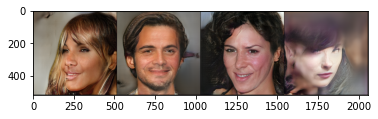

In [ ]:
num_images = 4
noise, _ = model.buildNoiseData(num_images)
with torch.no_grad():
    generated_images = model.test(noise)

# let's plot these images using torchvision and matplotlib
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(generated_images.clamp(min=-1, max=1), scale_each=True, normalize=True)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
